In [1]:
import pandas as pd
import numpy as np
import pickle
from IPython.display import display
import nltk
nltk.download('stopwords')

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Cleaning

This notebook contains the code to apply usual cleaning techniques to the data. The steps are as follows:

    + The columns with the most missing values are omitted.
    
    + The variables like balcony_avaliable, investment_rent_active, and construction_yearfinished are attempted to impute via text mining and locations.
    
    + Severe outliers which inhibit visualising histograms are removed.
    
    + Data specific to postal code regions are integrated.
    
    + Repeated listings are removed by choosing only the first advertised listing among them. They are called "censored" and marked by the status column, which is 0 for censored observations. In the cases when the date variable expose_offline_since is null, the record is count as censored, too.
    
   
    + Restricting the latest date by July 2019 to avoid from data collection bias (which could lead to an illusion as if the latest collected data sell faster).
    
    + The data from cities with less than 100 records are removed.
     
    + Further restrictions to the construction year to keep it between 1850 and 2030.
    
    + Ordinal encoding of the date variable (corresponds to "Date of First Advertisement" in the paper)


    + Ordinal encoding for the variable object_type (corresponds to "Property Type" in the paper)






# Select variables

In [45]:
all_cities_buy_new = pd.read_pickle("data_final/all_cities_buy_new.pkl")

In [46]:
all_cities_buy_new = all_cities_buy_new[~all_cities_buy_new.expose_price_sqm.isna()]

In [47]:
all_cities_buy_new = all_cities_buy_new[~all_cities_buy_new.address_geocoded_city.isna()]

In [48]:
selected_columns = ['source_record_id'
    ,'obj_unique_id_clus',
                   'address_geocoded_city', 
                    'address_geocoded_postalcode',
                    'address_lat',
                    'address_lng',
                   'balcony_available',
                    'construction_yearfinished',
                    'investment_rent_active',
                    'object_category',
                    'parking_available',
                   'structure_area_living',
                    'structure_rooms_living',
                    'expose_price_sqm',
                    'offline_corrected',
                    'online_corrected',
                    'weeks_on_market',
                    'expose_content_text_tokens'
                   ]


In [49]:
all_cities_buy_new = all_cities_buy_new[selected_columns]

# Missing Values

In [50]:
nans=[]
col_name=[]
for column in all_cities_buy_new.columns:
    nans.append(np.sum(pd.isna(all_cities_buy_new[[column]]))[0] / all_cities_buy_new.shape[0] )
    col_name.append(column)

missing = pd.DataFrame(np.array([col_name,nans]).T, columns = ["column", "miss_ratio"])
missing.miss_ratio = missing.miss_ratio.astype("float")

In [51]:
missing[missing.miss_ratio > 0.0].sort_values(by=['miss_ratio'],ascending =False)

,column,miss_ratio
6,balcony_available,0.603753
8,investment_rent_active,0.567076
7,construction_yearfinished,0.168778


# Missing investment_rent_active

In [52]:
def vermietet_finder(text):
    try:
        if len(re.findall("vermiet",text)) > 0:
            return(True)
        else:
            return(False)
    except:
            return(False)

In [53]:
import re
from tqdm.auto import tqdm
tqdm.pandas()
vermietet = all_cities_buy_new.expose_content_text_tokens.progress_apply(lambda x:vermietet_finder(x))


In [54]:
all_cities_buy_new.investment_rent_active.value_counts()/all_cities_buy_new.shape[0]

False    0.339438
True     0.093486
Name: investment_rent_active, dtype: float64

In [55]:
all_cities_buy_new.loc[:,"investment_rent_active"] = all_cities_buy_new["investment_rent_active"].fillna(vermietet)

In [56]:
all_cities_buy_new.investment_rent_active.value_counts()/all_cities_buy_new.shape[0]

False    0.8217
True     0.1783
Name: investment_rent_active, dtype: float64

# Missing Balkon

In [57]:
def balkon_finder(text):
    try:
        if len(re.findall("balkon|terras|teras",text)) > 0:
            return(True)
        else:
            return(False)
    except:
            return(False)

In [58]:
import re
from tqdm.auto import tqdm
tqdm.pandas()
balkon_ext = all_cities_buy_new.expose_content_text_tokens.progress_apply(lambda x:balkon_finder(x))

In [59]:
all_cities_buy_new.balcony_available.value_counts()/all_cities_buy_new.shape[0]

True     0.266881
False    0.129366
Name: balcony_available, dtype: float64

In [60]:
all_cities_buy_new.loc[:,"balcony_available"] = all_cities_buy_new["balcony_available"].fillna(balkon_ext)

In [61]:
all_cities_buy_new.balcony_available.value_counts()/all_cities_buy_new.shape[0]

True     0.543238
False    0.456762
Name: balcony_available, dtype: float64

# Missing Construction Year


The approach:

1. Text mining: Take the words surrounding years. Build a predictive model to regress TF-IDF representation on the binary variable whether or not the year is a construction year.

2. Construction years, which are still missing, are imputed by the postal code average.







In [62]:
constr_data = all_cities_buy_new.copy()
constr_data=constr_data[["source_record_id","expose_content_text_tokens","construction_yearfinished"]]
constr_data = constr_data.iloc[np.where([1 if s != [] else 0 for s in constr_data.expose_content_text_tokens])[0],]
constr_data = constr_data[~constr_data.expose_content_text_tokens.isna()]
constr_data["year_extracted"] = constr_data.expose_content_text_tokens.apply(lambda x: re.findall("(?i)((?:19|20)[0-9]{2})",x))

In [63]:
constr_data = constr_data.iloc[np.where([1 if s != [] else 0 for s in constr_data.year_extracted])[0],]

In [64]:
def surrounding_getter(year, text, context_length =3):
    
    context = []
    for y in year:
                  
        year_ext = re.findall("(?:[a-zA-Z-]+[^a-zA-Z-]+){0,"  +str(context_length)+ "}" + str(y) +
           "(?:[^a-zA-Z-]+|$)(?:[a-zA-Z-]+[^a-zA-Z-]*){0,"  +str(context_length)+ "}",text)
        if len(year_ext) > 0:
            context.append(year_ext[0])
        else:
            context.append("")
            
    return context

In [65]:
from tqdm.auto import tqdm
tqdm.pandas()
constr_data["stems"] =constr_data.progress_apply(lambda x: surrounding_getter(x["year_extracted"],
                                                                      x["expose_content_text_tokens"]),axis=1)

In [66]:
from tqdm import tqdm
def reshape_data(s1wf):

    s1wf = s1wf.iloc[np.where([1 if s != [] else 0 for s in s1wf.stems])[0],]
    s1wf = s1wf.iloc[np.where([1 if s != [] else 0 for s in s1wf.year_extracted])[0],]


    source = []
    stems=[]
    year=[]
    const=[]
    
    for idx in tqdm(range(s1wf.shape[0])):
        stems += s1wf.iloc[idx]["stems"]
        year += s1wf.iloc[idx]["year_extracted"]
        source += [s1wf.iloc[idx]["source_record_id"]] * len(s1wf.iloc[idx]["stems"])
        const +=  [s1wf.iloc[idx]["construction_yearfinished"]] * len(s1wf.iloc[idx]["stems"])
        
    df_dict = {'source_record_id': source, 
               'stems': stems,
               'year_extracted': year,
              'construction_yearfinished': const
            }  

    clean_data = pd.DataFrame(df_dict)

    clean_data.year_extracted=clean_data.year_extracted.astype(float)
    clean_data["constr_true"] = np.where(np.abs(clean_data.construction_yearfinished-clean_data.year_extracted ) <= 5.0,1,0)
    return(clean_data)

In [67]:
constr_data = reshape_data(constr_data)

100%|██████████| 873088/873088 [19:05<00:00, 762.49it/s]


In [68]:
constr_data.year_extracted=constr_data.year_extracted.astype(float)

In [69]:
constr_data["constr_true"] = np.where(np.abs(constr_data.construction_yearfinished-constr_data.year_extracted ) <= 5.0,1,0)

In [70]:
def tfidf_getter(tokens):
    from sklearn.feature_extraction.text import TfidfVectorizer

    tfidf_vectorizer = TfidfVectorizer(use_idf=True,min_df=0.001)
    X = tfidf_vectorizer.fit_transform(tokens)
    
    return(X,tfidf_vectorizer)



X,tfidf_vectorizer = tfidf_getter(constr_data.stems)
idx_constr = np.where(~pd.isna(constr_data.construction_yearfinished))[0] 

In [71]:
idx_impute = np.where(constr_data.construction_yearfinished.isna())[0]
data_constr = constr_data.iloc[idx_constr,:]
target_constr = np.array(constr_data["constr_true"].iloc[idx_constr])
print("Construction Year 1: ", target_constr[target_constr==1].shape[0])
print("Construction Year 0: ", target_constr[target_constr==0].shape[0],"\n")
X_constr = X[idx_constr]
X.shape

Construction Year 1:  900789
Construction Year 0:  1015548 



(2083749, 724)

In [72]:
from sklearn.model_selection import train_test_split

(X_train_constr, X_test_constr,
 y_train_constr, y_test_constr,
idx_train_constr, idx_test_constr) = train_test_split(X_constr,
                                                   target_constr,
                                                   idx_constr,                                        
                                                   test_size = 0.15, 
                                                   random_state = 42)

In [73]:
from sklearn.linear_model import LogisticRegression
lr_model_constr = LogisticRegression(C = 100,random_state = 0)
lr_model_constr.fit(X_train_constr, y_train_constr)

/home/ubuntu/anaconda3/envs/batuhanc/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
pred_train_constr = lr_model_constr.predict(X_train_constr)
pred_test_constr = lr_model_constr.predict(X_test_constr)

In [75]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print("Construction Accuracy Train: ", accuracy_score(pred_train_constr,y_train_constr))
print("Construction AUC Train     : ", roc_auc_score(pred_train_constr,y_train_constr))
print("Construction Accuracy Test : ", accuracy_score(pred_test_constr,y_test_constr))
print("Construction AUC Test      : ", roc_auc_score(pred_test_constr,y_test_constr))

print(classification_report(pred_test_constr,y_test_constr))

Construction Accuracy Train:  0.8821298728087785
Construction AUC Train     :  0.8816522718349444
Construction Accuracy Test :  0.8819868429749766
Construction AUC Test      :  0.8815319775317765
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    151581
           1       0.88      0.87      0.87    135870

    accuracy                           0.88    287451
   macro avg       0.88      0.88      0.88    287451
weighted avg       0.88      0.88      0.88    287451



In [76]:
from sklearn.linear_model import LogisticRegression
lr_model_constr_final = LogisticRegression(C = 100,random_state = 0)
lr_model_constr_final.fit(X_constr, target_constr)

/home/ubuntu/anaconda3/envs/batuhanc/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
X_constr_impute = X[idx_impute]

In [78]:
constr_data.loc[:,"prediction"] = 0
constr_data.loc[:,"prediction"][constr_data.construction_yearfinished.isna()] = lr_model_constr_final.predict(X_constr_impute)

/home/ubuntu/anaconda3/envs/batuhanc/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [79]:
constr_data[constr_data.construction_yearfinished.isna()].head()

,source_record_id,stems,year_extracted,construction_yearfinished,constr_true,prediction
0,2074824,energieausweis vorgeschrieb baujahr 1902 haus ...,1902.0,NaN,0,1
1,2074824,energieausweis vorgeschrieb baujahr 1902 haus ...,1902.0,NaN,0,1
2,1789908,energieausweis vorgeschrieb baujahr 1902 haus ...,1902.0,NaN,0,1
3,1789908,energieausweis vorgeschrieb baujahr 1902 haus ...,1902.0,NaN,0,1
4,5616102,nam im jahr 1900 in leisnig bank,1900.0,NaN,0,1


In [80]:
constr_data[constr_data.construction_yearfinished.isna() & (constr_data.prediction==1)].shape

(62674, 6)

In [81]:
imputed_constr_years = constr_data[["source_record_id","year_extracted"]][constr_data.prediction == 1]

In [83]:
imputed_constr_years.drop_duplicates(subset ="source_record_id", 
                     keep = False, inplace = True) 

In [84]:
all_cities_buy_new = pd.merge(all_cities_buy_new,imputed_constr_years,
                         how = "left", on = "source_record_id")

In [85]:
all_cities_buy_new.construction_yearfinished = all_cities_buy_new.construction_yearfinished.fillna(all_cities_buy_new.year_extracted)

In [86]:
#all_cities_buy_new.to_pickle("data_final/selected_data_imp_prg.pkl")

In [2]:
all_cities_buy_new = pd.read_pickle("data_final/selected_data_imp_prg.pkl")

In [3]:
all_cities_buy_new.construction_yearfinished = all_cities_buy_new.construction_yearfinished.astype(float)

In [4]:
baujahr_df=all_cities_buy_new[["address_geocoded_postalcode","construction_yearfinished"]].groupby("address_geocoded_postalcode").mean()

In [5]:
baujahr_df=baujahr_df.reset_index("address_geocoded_postalcode")

In [6]:
baujahr_df.columns =["address_geocoded_postalcode","construction_yearfinished_plz"]

In [7]:
all_cities_buy_new = pd.merge(all_cities_buy_new,baujahr_df,how="left", on ="address_geocoded_postalcode" )

In [8]:
all_cities_buy_new.construction_yearfinished = all_cities_buy_new.construction_yearfinished.fillna(all_cities_buy_new.construction_yearfinished_plz)

In [9]:
all_cities_buy_new.construction_yearfinished.isna().sum()

58

In [10]:
all_cities_buy_new = all_cities_buy_new[~all_cities_buy_new.construction_yearfinished.isna()]

In [11]:
all_cities_buy_new.shape

(1493231, 20)

# Outlier Removal

### Construction Year

In [ ]:
all_cities_buy_clean = all_cities_buy_clean[all_cities_buy_clean.construction_yearfinished >= 1000]

all_cities_buy_clean = all_cities_buy_clean[all_cities_buy_clean.construction_yearfinished <= 2030]

### Price per Square Meter

The old histogram





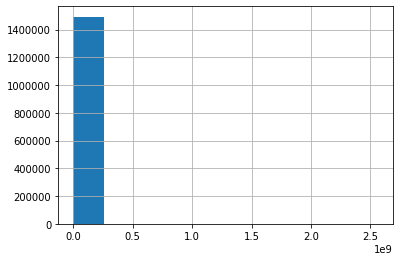

In [13]:
all_cities_buy_new.expose_price_sqm.hist()

In [14]:
np.quantile(all_cities_buy_new.expose_price_sqm,[0.1,0.25,0.5,0.75,0.9,1.0])

array([8.66666687e+02, 1.41483445e+03, 2.20370361e+03, 3.29904487e+03,
       4.66627979e+03, 2.56250214e+09])

### Price per Square Meter

Histogram after outlier removal:


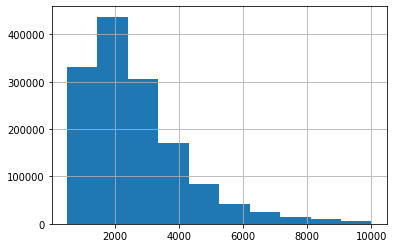

In [16]:
all_cities_buy_new[(all_cities_buy_new.expose_price_sqm <=10000) & (all_cities_buy_new.expose_price_sqm >= 500) ].expose_price_sqm.hist()

In [17]:
all_cities_buy_new = all_cities_buy_new[(all_cities_buy_new.expose_price_sqm <=10000) & (all_cities_buy_new.expose_price_sqm >= 500) ]

In [18]:
all_cities_buy_new.shape

(1425073, 20)

### Living Area
The old histogram of living area



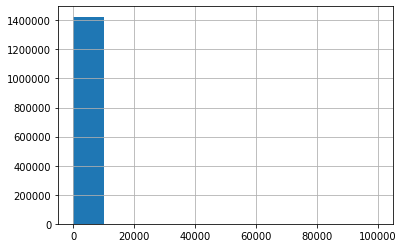

In [19]:
all_cities_buy_new.structure_area_living.hist()

### Living Area
The histogram after outlier removal:


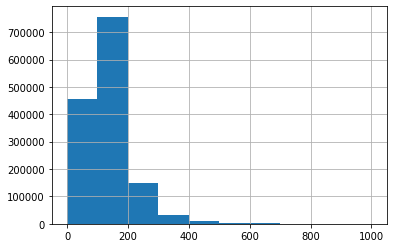

In [24]:
all_cities_buy_new.structure_area_living[all_cities_buy_new.structure_area_living <= 1000 ].hist()

# Number of Rooms


The histogram after removing listings with room numbers greater or equal than 20.





In [21]:
all_cities_buy_new = all_cities_buy_new[all_cities_buy_new.structure_rooms_living < 20]

In [22]:
all_cities_buy_new.shape

(1414388, 20)

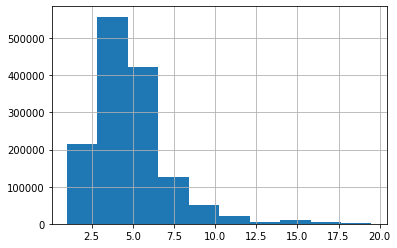

In [20]:
all_cities_buy_new[all_cities_buy_new.structure_rooms_living < 20].structure_rooms_living.hist()

In [25]:
all_cities_buy_new = all_cities_buy_new[all_cities_buy_new.structure_area_living <= 1000 ]

In [26]:
all_cities_buy_new.shape

(1413973, 20)

In [27]:
all_cities_buy_new.columns

Index(['source_record_id', 'obj_unique_id_clus', 'address_geocoded_city',
       'address_geocoded_postalcode', 'address_lat', 'address_lng',
       'balcony_available', 'construction_yearfinished',
       'investment_rent_active', 'object_category', 'parking_available',
       'structure_area_living', 'structure_rooms_living', 'expose_price_sqm',
       'offline_corrected', 'online_corrected', 'weeks_on_market',
       'expose_content_text_tokens', 'year_extracted',
       'construction_yearfinished_plz'],
      dtype='object')

# Postal Code Data

In [28]:
plz_all = pd.read_excel("ultimate_data/plz_all.xlsx")

In [29]:
plz_all.columns = ['zip_city',"zip_code",
                   "zip_area_km2","zip_lat",
                   "zip_lng","zip_population",
                   "zip_population_density",
                  "city_lng","city_lat"]



In [38]:
plz_all.zip_code = plz_all.zip_code.astype(str)

In [40]:
import re
plz_all.zip_code = plz_all.zip_code.apply(lambda x: re.sub("X","",x))




In [41]:
plz_all.head(100)

,zip_city,zip_code,zip_area_km2,zip_lat,zip_lng,zip_population,zip_population_density,city_lng,city_lat
0,Ã–hningen,78337,28.179802,47.678529,8.902334,3509,124.521814,8.902334,47.678529
1,Ã–hringen,74613,67.821120,49.210470,9.501625,22513,331.946745,9.501625,49.210470
2,Ã–lbronn-DÃ¼rrn,75248,15.620030,48.969068,8.754797,3392,217.157080,8.754797,48.969068
3,Ã–pfingen,89614,8.870305,48.289420,9.807230,2260,254.782667,9.807230,48.289420
4,Ã–stringen,76684,53.281234,49.189841,8.752244,12518,234.942006,8.752244,49.189841
5,Ã–tigheim,76470,10.950756,48.886503,8.239226,4471,408.282325,8.239226,48.886503
6,Ã–tisheim,75443,14.257361,48.963278,8.800028,4728,331.618177,8.800028,48.963278
7,Ã–tzingen,56244,97.560057,50.578030,7.764133,12836,131.570239,7.764133,50.578030
8,Aach,78267,10.657357,47.843673,8.858195,2179,204.459708,8.858195,47.843673
9,Aachen,52068,5.442057,50.779753,6.125915,15378,2825.769530,6.104830,50.773188


In [59]:
all_cities_buy_pop = pd.merge(all_cities_buy_new, plz_all, how="left", left_on="address_geocoded_postalcode",
                             right_on = "zip_code")

In [60]:
all_cities_buy_pop=all_cities_buy_pop[~all_cities_buy_pop.zip_code.isna()]

In [61]:
all_cities_buy_pop.shape

(1410667, 29)

In [62]:
all_cities_buy_pop.zip_code = all_cities_buy_pop.zip_code.astype(str)

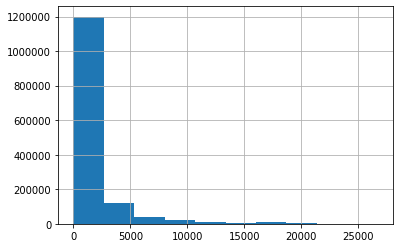

In [63]:
all_cities_buy_pop.zip_population_density.hist()

In [64]:
market_size = all_cities_buy_pop[["address_geocoded_postalcode",'obj_unique_id_clus']].groupby("address_geocoded_postalcode").count()

In [65]:
market_size=market_size.reset_index("address_geocoded_postalcode")
market_size.columns = ["address_geocoded_postalcode","zip_market_size"]



In [66]:
all_cities_buy_pop = pd.merge(all_cities_buy_pop,market_size,on = "address_geocoded_postalcode")

In [67]:
all_cities_buy_pop.columns

Index(['source_record_id', 'obj_unique_id_clus', 'address_geocoded_city',
       'address_geocoded_postalcode', 'address_lat', 'address_lng',
       'balcony_available', 'construction_yearfinished',
       'investment_rent_active', 'object_category', 'parking_available',
       'structure_area_living', 'structure_rooms_living', 'expose_price_sqm',
       'offline_corrected', 'online_corrected', 'weeks_on_market',
       'expose_content_text_tokens', 'year_extracted',
       'construction_yearfinished_plz', 'zip_city', 'zip_code', 'zip_area_km2',
       'zip_lat', 'zip_lng', 'zip_population', 'zip_population_density',
       'city_lng', 'city_lat', 'zip_market_size'],
      dtype='object')

In [68]:
city_lat_deviance = all_cities_buy_pop["address_lat"] - all_cities_buy_pop["city_lat"]
city_lon_deviance = all_cities_buy_pop["address_lng"] - all_cities_buy_pop["city_lng"]
all_cities_buy_pop["city_distance"] = np.sqrt(city_lat_deviance**2 + city_lon_deviance**2)

In [69]:
nans=[]
col_name=[]
for column in all_cities_buy_pop.columns:
    nans.append(np.sum(pd.isna(all_cities_buy_pop[[column]]))[0] / all_cities_buy_pop.shape[0] )
    col_name.append(column)

missing = pd.DataFrame(np.array([col_name,nans]).T, columns = ["column", "miss_ratio"])
missing.miss_ratio = missing.miss_ratio.astype("float")

In [70]:
missing[missing.miss_ratio > 0.0].sort_values(by=['miss_ratio'],ascending =False)

,column,miss_ratio
18,year_extracted,0.974258
20,zip_city,0.000296


In [55]:
all_cities_buy_pop = all_cities_buy_pop[~all_cities_buy_pop.zip_city.isna()]

In [71]:
all_cities_buy_pop = all_cities_buy_pop.drop(["year_extracted","zip_city","zip_code"], axis = 1)

In [72]:
all_cities_buy_pop.head()

,source_record_id,obj_unique_id_clus,address_geocoded_city,address_geocoded_postalcode,address_lat,address_lng,balcony_available,construction_yearfinished,investment_rent_active,object_category,parking_available,structure_area_living,structure_rooms_living,expose_price_sqm,offline_corrected,online_corrected,weeks_on_market,expose_content_text_tokens,construction_yearfinished_plz,zip_area_km2,zip_lat,zip_lng,zip_population,zip_population_density,city_lng,city_lat,zip_market_size,city_distance
0,dNED+BBBShbdRNqYaBYyhkusfUk=,dNED+BBBShbdRNqYaBYyhkusfUk=clu0,Dresden,01067,51.060257,13.717804,True,2013.0,False,APARTMENT,True,147.77,5.0,4053.596806,2018-09-10,2018-01-01,37.0,objektbeschreib wohntraum befindet 2 obergesch...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.049898
1,UWoXjGpsVk/9nhqVsp0JABXYj4M=,UWoXjGpsVk/9nhqVsp0JABXYj4M=,Dresden,01067,51.060257,13.717804,False,1900.0,False,APARTMENT,False,60.00,3.0,2033.333333,2018-04-16,2018-02-19,9.0,objekt mehrfamilienhaus befindet in seitenstra...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.049898
2,4361933,4361933,Dresden,01067,51.057290,13.719990,True,2019.0,False,APARTMENT,True,43.00,2.0,4511.627930,2019-03-25,2019-02-11,7.0,absolut stadtnah umgeb fusslauf erreichbar idy...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.047165
3,7471690,7471690,Dresden,01067,51.057790,13.714460,True,1995.0,True,APARTMENT,True,36.00,1.0,1916.666626,2019-08-05,2019-08-05,1.0,schon apartment befindet im 1995 neu erbaut vo...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.052700
4,3633260,4361933,Dresden,01067,51.057290,13.719990,True,2019.0,False,APARTMENT,True,43.00,2.0,4511.629883,2019-01-28,2018-12-24,6.0,absolut stadtnah umgeb fusslauf erreichbar idy...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.047165


In [73]:
all_cities_buy_pop.address_geocoded_postalcode = all_cities_buy_pop.address_geocoded_postalcode.astype(str)

In [84]:
all_cities_buy_pop.head()

,source_record_id,obj_unique_id_clus,address_geocoded_city,address_geocoded_postalcode,address_lat,address_lng,balcony_available,construction_yearfinished,investment_rent_active,object_category,parking_available,structure_area_living,structure_rooms_living,expose_price_sqm,offline_corrected,online_corrected,weeks_on_market,expose_content_text_tokens,construction_yearfinished_plz,zip_area_km2,zip_lat,zip_lng,zip_population,zip_population_density,city_lng,city_lat,zip_market_size,city_distance
0,dNED+BBBShbdRNqYaBYyhkusfUk=,dNED+BBBShbdRNqYaBYyhkusfUk=clu0,Dresden,01067,51.060257,13.717804,True,2013.0,False,APARTMENT,True,147.77,5.0,4053.596806,2018-09-10,2018-01-01,37.0,objektbeschreib wohntraum befindet 2 obergesch...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.049898
1,UWoXjGpsVk/9nhqVsp0JABXYj4M=,UWoXjGpsVk/9nhqVsp0JABXYj4M=,Dresden,01067,51.060257,13.717804,False,1900.0,False,APARTMENT,False,60.00,3.0,2033.333333,2018-04-16,2018-02-19,9.0,objekt mehrfamilienhaus befindet in seitenstra...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.049898
2,4361933,4361933,Dresden,01067,51.057290,13.719990,True,2019.0,False,APARTMENT,True,43.00,2.0,4511.627930,2019-03-25,2019-02-11,7.0,absolut stadtnah umgeb fusslauf erreichbar idy...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.047165
3,7471690,7471690,Dresden,01067,51.057790,13.714460,True,1995.0,True,APARTMENT,True,36.00,1.0,1916.666626,2019-08-05,2019-08-05,1.0,schon apartment befindet im 1995 neu erbaut vo...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.052700
4,3633260,4361933,Dresden,01067,51.057290,13.719990,True,2019.0,False,APARTMENT,True,43.00,2.0,4511.629883,2019-01-28,2018-12-24,6.0,absolut stadtnah umgeb fusslauf erreichbar idy...,1993.316667,6.853574,51.060257,13.717804,11957.0,1744.637097,13.766437,51.04909,132,0.047165


In [ ]:
all_cities_buy_pop = all_cities_buy_pop[all_cities_buy_pop.zip_population > 0]

In [74]:
#all_cities_buy_pop.to_pickle("data_final/all_cities_buy_geo.pkl")

# Remove Repeated Listings

In [119]:
def select_records(data):
    data = data.reset_index(drop=True)
    result = data.iloc[0].copy()
    result["repeated"] = data.shape[0]
    return(result)
 

In [120]:
from tqdm.auto import tqdm
tqdm.pandas()
all_cities_buy_clean = all_cities_buy_pop.groupby(["obj_unique_id_clus"]).progress_apply(select_records)

In [127]:
all_cities_buy_clean["status"] = np.where(all_cities_buy_clean["repeated"] > 1, 0,1)

In [128]:
all_cities_buy_clean.weeks_on_market = all_cities_buy_clean.weeks_on_market.astype(int)

(250846, 1)

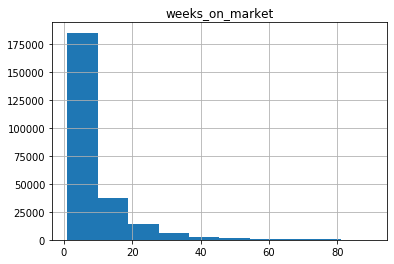

In [129]:
all_cities_buy_clean.loc[all_cities_buy_clean.status == 0,["weeks_on_market"]].hist()
all_cities_buy_clean.loc[all_cities_buy_clean.status == 0,["weeks_on_market"]].shape

(591213, 1)

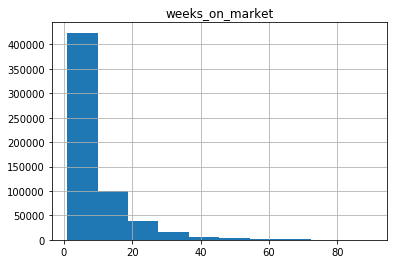

In [130]:
all_cities_buy_clean.loc[all_cities_buy_clean.status == 1,["weeks_on_market"]].hist()
all_cities_buy_clean.loc[all_cities_buy_clean.status == 1,["weeks_on_market"]].shape

In [132]:
all_cities_buy_clean = all_cities_buy_clean.reset_index(drop=True)

In [134]:
all_cities_buy_clean.address_geocoded_postalcode = all_cities_buy_clean.address_geocoded_postalcode.astype(str)

In [135]:
cond = all_cities_buy_clean.address_geocoded_postalcode.str.len() == 4
all_cities_buy_clean.loc[cond,"address_geocoded_postalcode" ] = "0" + all_cities_buy_clean.loc[cond,"address_geocoded_postalcode" ]

In [136]:
all_cities_buy_clean["time_online"]=(all_cities_buy_clean["online_corrected"].dt.normalize().astype(int)/1e+11)

In [9]:
all_cities_buy_clean.head()

,source_record_id,obj_unique_id_clus,address_geocoded_city,address_geocoded_postalcode,address_lat,address_lng,balcony_available,construction_yearfinished,investment_rent_active,object_category,parking_available,structure_area_living,structure_rooms_living,expose_price_sqm,offline_corrected,online_corrected,weeks_on_market,expose_content_text_tokens,construction_yearfinished_plz,zip_area_km2,zip_lat,zip_lng,zip_population,zip_population_density,city_lng,city_lat,zip_market_size,city_distance,repeated,status,time_online
0,+++eomt1qbpF2qKAQUspyzfrCrI=,+++eomt1qbpF2qKAQUspyzfrCrI=,Tamm,71732,48.924760,9.118310,True,1974.000000,False,APARTMENT,True,85.97,3.0,3012.678841,2018-05-14,2018-04-09,6,objekt objekt ist 1974 gebaut bezog in gut lau...,2000.790191,8.512862,48.924123,9.124472,12037.0,1413.978047,9.124472,48.924123,368,0.006195,1,1,15232320.0
1,++/V2h+LLOegxbGDhdr/ltDNYgU=,++/V2h+LLOegxbGDhdr/ltDNYgU=,Köditz,95189,50.346824,11.834231,True,1995.000000,False,APARTMENT,True,65.00,2.0,1069.230769,2018-07-30,2018-04-30,14,objekt exklusiv angebot wohnung handelt ca 65 ...,1960.500000,31.424002,50.346779,11.834030,2571.0,81.816442,11.834030,50.346779,38,0.000206,1,1,15250464.0
2,++0sIeDr/I+q8NqpVXA8msKQJvo=,++0sIeDr/I+q8NqpVXA8msKQJvo=,Stuttgart,70180,48.764730,9.171050,False,1898.000000,False,APARTMENT,False,108.62,3.5,6398.453324,2018-05-14,2018-04-09,6,objektbeschreib wohnung befindet in zentral la...,1946.539906,1.348814,48.762775,9.175018,15149.0,11231.351389,9.176605,48.777428,227,0.013860,1,1,15232320.0
3,++5ib/BSsUvCTGEECLEoCGjD114=,++5ib/BSsUvCTGEECLEoCGjD114=,Dresden,01328,51.056054,13.885785,False,2000.000000,False,HOUSE,True,184.35,5.0,1621.914836,2018-05-14,2018-03-26,8,objektbeschreib bieterverfahr angegeb kaufprei...,1999.626692,41.149005,51.042173,13.907670,12342.0,299.934350,13.766437,51.049090,544,0.119551,1,1,15220224.0
4,++6AlhTk/dX3l6MZIHOu/d7ZqnI=,++6AlhTk/dX3l6MZIHOu/d7ZqnI=,Limburgerhof,67117,49.415265,8.393108,False,1982.545455,False,APARTMENT,True,68.00,2.0,2250.000000,2018-03-12,2018-03-05,2,objektbeschreib wohnung befindet in gepflegt m...,1982.545455,8.905767,49.415205,8.393127,10779.0,1210.339267,8.393127,49.415205,240,0.000063,1,1,15202080.0


In [10]:
all_cities_buy_clean.shape

(841916, 31)

In [32]:
#all_cities_buy_clean.to_pickle("data_final/all_cities_buy_clean.pkl")

# Data Selection

In [2]:
all_cities_buy = pd.read_pickle("all_cities_buy_clean.pkl")

In [3]:
all_cities_buy.shape

(949818, 45)

In [4]:
all_cities_buy.online_corrected.max()

Timestamp('2019-09-16 00:00:00')

In [5]:
tmp =tmp[tmp.index < "2019-08-01"]

all_cities_buy = all_cities_buy[all_cities_buy.online_corrected.isin(tmp.index)]

all_cities_buy.shape

all_cities_buy.online_corrected.min()

all_cities_buy.online_corrected.max()

all_cities_buy.columns

all_cities_buy.address_geocoded_city = all_cities_buy.address_geocoded_city.str.strip()

city_counts = all_cities_buy[["address_geocoded_city","unique_obj_id_clus"]].groupby("address_geocoded_city").count()

city_counts.columns = ["counts"]

city_counts.sort_values("counts",ascending = False).head(100)

all_cities_buy = pd.merge(all_cities_buy, city_counts,how="left", on= "address_geocoded_city")

all_cities_buy[all_cities_buy.expose_offline_since.isna()]["status"]

all_cities_buy.loc[all_cities_buy.expose_offline_since.isna(),"status"] = 0

# Remove cities with less than 100 records

all_cities_buy = all_cities_buy[all_cities_buy.counts > 100]

all_cities_buy= all_cities_buy[all_cities_buy.construction_yearfinished >= 1850]
all_cities_buy= all_cities_buy[all_cities_buy.construction_yearfinished <= 2030]


all_cities_buy.shapetmp = all_cities_buy.set_index('online_corrected')

In [6]:
tmp =tmp[tmp.index < "2019-08-01"]

In [7]:
all_cities_buy = all_cities_buy[all_cities_buy.online_corrected.isin(tmp.index)]

In [8]:
all_cities_buy.shape

(915347, 45)

In [9]:
all_cities_buy.online_corrected.min()

Timestamp('2018-01-01 00:00:00')

In [10]:
all_cities_buy.online_corrected.max()

Timestamp('2019-07-29 00:00:00')

In [11]:
all_cities_buy.columns

Index(['dw_created_at', 'dw_modified_at', 'dw_is_active', 'source_record_id', 'source_type', 'address_geocoded_city', 'address_geocoded_postalcode', 'address_lat', 'address_lng', 'balcony_available', 'construction_yearfinished', 'investment_rent_active', 'object_category', 'object_type', 'parking_available', 'structure_area_living', 'structure_rooms_living', 'expose_price_sqm', 'expose_price_total', 'expose_offline_since', 'expose_online_since', 'expose_online_until', 'expose_type', 'offline_corrected', 'online_corrected', 'weeks_on_market', 'month_advertised', 'year_advertised', 'expose_content_text_tokens', 'unique_obj_id_clus', 'zip_city', 'zip_code', 'zip_area_km2', 'zip_lat', 'zip_lng', 'zip_population', 'zip_population_density', 'city_lng', 'city_lat', 'zip_market_size', 'city_lat_deviance', 'city_lon_deviance', 'city_distance', 'repeated', 'status'], dtype='object')

In [12]:
all_cities_buy.address_geocoded_city = all_cities_buy.address_geocoded_city.str.strip()

In [13]:
city_counts = all_cities_buy[["address_geocoded_city","unique_obj_id_clus"]].groupby("address_geocoded_city").count()

In [14]:
city_counts.columns = ["counts"]

In [15]:
city_counts.sort_values("counts",ascending = False).head(100)

,counts
address_geocoded_city,
Berlin,37906
Hamburg,14480
München,14164
Köln,8797
Leipzig,7885
Frankfurt am Main,6499
Dresden,6372
Bremen,6081
Düsseldorf,5966


In [16]:
all_cities_buy = pd.merge(all_cities_buy, city_counts,how="left", on= "address_geocoded_city")

In [17]:
all_cities_buy[all_cities_buy.expose_offline_since.isna()]["status"]

2         1
4         1
178       1
236       0
357       1
         ..
914468    1
914747    0
914858    1
914859    0
915085    1
Name: status, Length: 74661, dtype: int64

In [18]:
all_cities_buy.loc[all_cities_buy.expose_offline_since.isna(),"status"] = 0

# Remove cities with less than 100 records

In [19]:
all_cities_buy = all_cities_buy[all_cities_buy.counts > 100]

In [20]:
all_cities_buy= all_cities_buy[all_cities_buy.construction_yearfinished >= 1850]
all_cities_buy= all_cities_buy[all_cities_buy.construction_yearfinished <= 2030]


In [20]:
all_cities_buy.shape

(915342, 46)

# Date of First Advertisement

In [21]:
all_cities_buy["time_online"] = all_cities_buy.online_corrected.apply(lambda x: pd.to_datetime(x).value)

In [22]:
from sklearn.preprocessing import MinMaxScaler

time_scaler = MinMaxScaler()
all_cities_buy["time_online"]=time_scaler.fit_transform(all_cities_buy["time_online"].values.reshape(-1,1))

In [25]:
import pickle

with open("ultimate_data/time_scaler.pkl","wb") as handle:
    pickle.dump(time_scaler, handle)

# Object Type

In [26]:
all_cities_buy.object_type.value_counts()

ONE_TWO_FAMILY_HOUSE    284833
REGULAR_APARTMENT       222939
HOUSE_UNKNOWN            94709
APARTMENT_UNKNOWN        85127
MULTI_FAMILY_HOUSE       55208
SEMI_DETACHED_HOUSE      46193
TERRACED_HOUSE           33639
SPECIAL_BUILDING         31756
BUNGALOW                 20484
MAISONETTE               16722
MANSION                   9523
PENTHOUSE                 7582
FARMHOUSE                 5652
LOFT                       975
Name: object_type, dtype: int64

In [27]:
all_cities_buy.object_type=all_cities_buy.object_type.replace("APARTMENT_UNKNOWN","REGULAR_APARTMENT")

In [28]:
from sklearn.preprocessing import OrdinalEncoder
enc_ot = OrdinalEncoder(categories=[["REGULAR_APARTMENT", "ONE_TWO_FAMILY_HOUSE",
                                    "SEMI_DETACHED_HOUSE","HOUSE_UNKNOWN","MULTI_FAMILY_HOUSE",
                                     "TERRACED_HOUSE","SPECIAL_BUILDING","MAISONETTE",
                                    "BUNGALOW","PENTHOUSE","MANSION","FARMHOUSE","LOFT"]])

enc_ot.fit(all_cities_buy.object_type.values.reshape(-1,1))

OrdinalEncoder(categories=[['REGULAR_APARTMENT', 'ONE_TWO_FAMILY_HOUSE',
                            'SEMI_DETACHED_HOUSE', 'HOUSE_UNKNOWN',
                            'MULTI_FAMILY_HOUSE', 'TERRACED_HOUSE',
                            'SPECIAL_BUILDING', 'MAISONETTE', 'BUNGALOW',
                            'PENTHOUSE', 'MANSION', 'FARMHOUSE', 'LOFT']],
               dtype=<class 'numpy.float64'>)

In [29]:
all_cities_buy["object_type_ordinal"]=enc_ot.transform(all_cities_buy.object_type.values.reshape(-1,1))

# Seasons

In [30]:
seasons = all_cities_buy.online_corrected.dt.month.astype(str)

In [31]:
seasons=seasons.replace(["12","1","2"],"Winter")
seasons=seasons.replace(["3","4","5"],"Spring")
seasons=seasons.replace(["6","7","8"], "Summer")
seasons=seasons.replace(["9","10","11"],"Fall")

In [32]:
all_cities_buy["season"] = seasons

# Select Columns

In [45]:
all_cities_buy.columns

Index(['dw_created_at', 'dw_modified_at', 'dw_is_active', 'source_record_id', 'source_type', 'address_geocoded_city', 'address_geocoded_postalcode', 'address_lat', 'address_lng', 'balcony_available', 'construction_yearfinished', 'investment_rent_active', 'object_category', 'object_type', 'parking_available', 'structure_area_living', 'structure_rooms_living', 'expose_price_sqm', 'expose_price_total', 'expose_offline_since', 'expose_online_since', 'expose_online_until', 'expose_type', 'offline_corrected', 'online_corrected', 'weeks_on_market', 'month_advertised', 'year_advertised', 'expose_content_text_tokens', 'unique_obj_id_clus', 'zip_city', 'zip_code', 'zip_area_km2', 'zip_lat', 'zip_lng', 'zip_population', 'zip_population_density', 'city_lng', 'city_lat', 'zip_market_size', 'city_lat_deviance', 'city_lon_deviance', 'city_distance', 'repeated', 'status', 'counts', 'time_online', 'object_type_ordinal', 'season', 'month_year'], dtype='object')

In [46]:
numeric_columns = ['address_lat','address_lng',
                  'construction_yearfinished','structure_area_living',
                  'structure_rooms_living',
                  'zip_population_density',"object_type_ordinal",
                  'zip_market_size','city_distance','time_online',
                   'expose_price_sqm',
                   'weeks_on_market','status']

string_columns = ['balcony_available','investment_rent_active',
                 'parking_available',"object_type","season"]




In [47]:
for col in all_cities_buy[string_columns]:
    all_cities_buy[col] = all_cities_buy[col].astype(str) 
    
for col in all_cities_buy[numeric_columns]:
    all_cities_buy[col] = all_cities_buy[col].astype('float32') 
    
    
    
    
    
    

In [48]:
dummy_vars = pd.get_dummies(all_cities_buy[string_columns],
                            drop_first =True)

In [49]:
df = pd.concat([dummy_vars,all_cities_buy[numeric_columns]],axis=1)

In [50]:
df_info = all_cities_buy[["unique_obj_id_clus","address_geocoded_city","address_geocoded_postalcode",
                         "offline_corrected", "online_corrected","season","object_type"]]

In [51]:
df_info.head()

,unique_obj_id_clus,address_geocoded_city,address_geocoded_postalcode,offline_corrected,online_corrected,season,object_type
0,0clu0,München,81829,2018-05-07 00:00:00,2018-01-15 00:00:00,Winter,ONE_TWO_FAMILY_HOUSE
1,0clu1,München,81829,2018-05-07 00:00:00,2018-01-15 00:00:00,Winter,ONE_TWO_FAMILY_HOUSE
2,100,Essen,45257,2018-05-14 00:00:00,2018-05-14 00:00:00,Spring,MAISONETTE
3,1000,Verden (Aller),27283,2018-04-09 00:00:00,2018-01-15 00:00:00,Winter,ONE_TWO_FAMILY_HOUSE
4,10000,Blankenfelde-Mahlow,15831,2018-05-14 00:00:00,2018-05-07 00:00:00,Spring,HOUSE_UNKNOWN


In [52]:
df.head()

,balcony_available_True,investment_rent_active_True,parking_available_True,object_type_FARMHOUSE,object_type_HOUSE_UNKNOWN,object_type_LOFT,object_type_MAISONETTE,object_type_MANSION,object_type_MULTI_FAMILY_HOUSE,object_type_ONE_TWO_FAMILY_HOUSE,object_type_PENTHOUSE,object_type_REGULAR_APARTMENT,object_type_SEMI_DETACHED_HOUSE,object_type_SPECIAL_BUILDING,object_type_TERRACED_HOUSE,season_Spring,season_Summer,season_Winter,address_lat,address_lng,construction_yearfinished,structure_area_living,structure_rooms_living,zip_population_density,object_type_ordinal,zip_market_size,city_distance,time_online,expose_price_sqm,weeks_on_market,status
0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.133854,11.688066,2018.0,127.0,6.0,2014.288696,1.0,346.0,0.129487,0.024390,6275.590332,17.0,0.0
1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,48.133854,11.688066,2018.0,140.0,6.0,2014.288696,1.0,346.0,0.129487,0.024390,6900.000000,17.0,0.0
2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,51.385792,7.085973,1982.0,120.0,4.5,906.219055,7.0,216.0,0.091109,0.231707,1791.666626,1.0,0.0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,52.937435,9.236212,1954.0,110.0,5.0,370.996307,1.0,272.0,0.000116,0.024390,2036.363647,13.0,0.0
4,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,52.333286,13.414221,2015.0,179.0,5.0,393.366364,3.0,637.0,0.009717,0.219512,6983.240234,2.0,0.0


In [ ]:
all_cities_buy.columns

numeric_columns = ['address_lat','address_lng',
                  'construction_yearfinished','structure_area_living',
                  'structure_rooms_living',
                  'zip_population_density',"object_type_ordinal",
                  'zip_market_size','city_distance','time_online',
                   'expose_price_sqm',
                   'weeks_on_market','status']

string_columns = ['balcony_available','investment_rent_active',
                 'parking_available',"object_type","season"]

for col in all_cities_buy[string_columns]:
    all_cities_buy[col] = all_cities_buy[col].astype(str) 
    
for col in all_cities_buy[numeric_columns]:
    all_cities_buy[col] = all_cities_buy[col].astype('float32') 

dummy_vars = pd.get_dummies(all_cities_buy[string_columns],
                            drop_first =True)

df = pd.concat([dummy_vars,all_cities_buy[numeric_columns]],axis=1)

df_info = all_cities_buy[["unique_obj_id_clus","address_geocoded_city","address_geocoded_postalcode",
                         "offline_corrected", "online_corrected","season","object_type"]]

df_info.head()

df.head()

# Save the Data

In [61]:
#df.to_pickle("ultimate_data/df_price_1901.pkl")

In [62]:
#df_info.to_pickle("ultimate_data/df_info_price_1901.pkl")